# Topic Modeling on "DataScience" tweets

The focus of this project is to discover trending subtopics under the umbrella of "Data Science".

Steps:

- Harvest Tweets using Search API (TweetRead.py), store tweets in a json file
- Extracting the text of each tweet (TweetText.py), store the text in a csv file
- Clean the text data and explore what popular hashtags are being used
- Use unsupervised machine learning algorithms (LDA & NMF) to explore the topics of the tweets

## Importing modules

In [2]:
# packages to store and manipulate data
import pandas as pd
import numpy as np

# plotting packages
import matplotlib.pyplot as plt
import seaborn as sns

# model building package
import sklearn

# package to clean text
import re

## Loading the tweets

In [28]:
# read in the tweets
df = pd.read_csv('TweetText.csv',sep='\n')

In [29]:
# make sure all the rows are read in correctly
df.shape

(218, 1)

In [30]:
df.head()

,tweet
0,RT @KirkDBorne: Biometric #IoT sensors shape t...
1,————
2,#BigData #DataScience #AI #Compute…
3,RT @KirkDBorne: Understanding the 3 flavors of...
4,RT @R_Demidchuk: 30 #Blockchain use-cases outs...


In [69]:
# find out how many of our tweets are unique, because people retweet each other all the time
df.tweet.unique().size

113

## Exploratory Data Analysis

### Identifying retweets

In [43]:
# creating a new column to flag retweets
df['is_retweet'] = df['tweet'].apply(lambda x:x[:2]=='RT')

In [44]:
# number of retweets
df['is_retweet'].sum()

84

### Finding the 10 most repeated tweets

In [38]:
df.groupby(['tweet']).size().reset_index(name='counts').sort_values('counts', ascending=False).head(10)

,tweet,counts
0,#Mpgvip #defstar5 #makeyourownlane #smm #Mark...,10
47,RT @Ceo_Branding: The War Over #5G,10
101,https://t.co/8z2jubcI7N,10
51,RT @GavLaaaaaaaa: [Self Promotion] I’m a softw...,6
6,#ArtificialIntelligence #MachineLearning #Deep...,5
82,RT @marcusborba: #ComputerVision in action!,5
108,————,4
92,The #Data #Science Course 2020: Complete #Data...,4
68,RT @couponed_code: https://t.co/5WEGwM6jhX,4
16,#Data #DeepLearning #Analytics #DataS…,4


### Finding popular hashtags

In [54]:
def find_hashtags(tweet):
    '''This function will extract hashtags'''
    return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', tweet)  

In [55]:
df['hashtags'] = df.tweet.apply(find_hashtags)

In [58]:
df.head()

,tweet,is_retweet,hashtags
0,RT @KirkDBorne: Biometric #IoT sensors shape t...,True,[#IoT]
1,————,False,[]
2,#BigData #DataScience #AI #Compute…,False,"[#BigData, #DataScience, #AI, #Compute]"
3,RT @KirkDBorne: Understanding the 3 flavors of...,True,"[#MachineLearning, #ReinforcementLearning]"
4,RT @R_Demidchuk: 30 #Blockchain use-cases outs...,True,"[#Blockchain, #Fintech]"


In [59]:
# remove the rows without hashtag and store the results in a new dataframe
hashtags_list_df = df.loc[df.hashtags.apply(lambda hashtags_list: hashtags_list !=[]),['hashtags']]

In [60]:
hashtags_list_df.head()

,hashtags
0,[#IoT]
2,"[#BigData, #DataScience, #AI, #Compute]"
3,"[#MachineLearning, #ReinforcementLearning]"
4,"[#Blockchain, #Fintech]"
5,"[#MachineLearning, #BigData, #ArtificialIntell..."


In [66]:
# flatten the hashtag dataframe
hashtags_df = pd.DataFrame([hashtag 
                            for hashtags_list in hashtags_list_df.hashtags
                            for hashtag in hashtags_list],
                            columns=['hashtag'])

In [67]:
hashtags_df.head()

,hashtag
0,#IoT
1,#BigData
2,#DataScience
3,#AI
4,#Compute


In [71]:
# shape of hashtags_df
hashtags_df.shape

(429, 1)

In [72]:
# number of unique hashtags
hashtags_df['hashtag'].unique().size

91

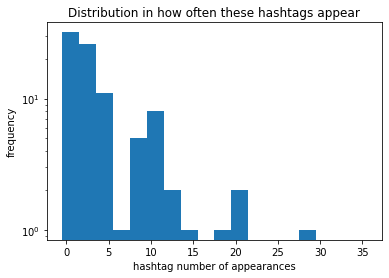

In [79]:
# number of times each hashtag appears
counts = hashtags_df.groupby(['hashtag']).size()\
                              .reset_index(name='counts')\
                              .counts

# define bins for histogram                              
my_bins = np.arange(0,counts.max()+2, 2)-0.5

# plot histogram of tweet counts
plt.figure()
plt.title('Distribution in how often these hashtags appear')
plt.hist(counts, bins = my_bins)
plt.xlabels = np.arange(1,counts.max()+1, 1)
plt.xlabel('hashtag number of appearances')
plt.ylabel('frequency')
plt.yscale('log', nonposy='clip')
plt.show()

## Correlation between hashtags

In [80]:
# count the appearances of the hashtags
popular_hashtags = hashtags_df.groupby(['hashtag']).size().reset_index(name='counts')\
                              .sort_values('counts', ascending=False).reset_index(drop = True)
# take hashtags which appear at least 5 times
min_appearance = 5
# create a set of popular hashtags
popular_hashtags_set = set(popular_hashtags[popular_hashtags.counts>=min_appearance]['hashtag'])

In [86]:
# show some popular hashtags
list(popular_hashtags_set)[:5]

['#RStats', '#Marketing', '#Python', '#datascience', '#Ja']

In [87]:
# mutate a new column with only the popular hashtags
hashtags_list_df['popular_hashtags'] = hashtags_list_df.hashtags.apply(lambda hashtag_list: [hashtag 
                                                                                             for hashtag in hashtag_list
                                                                                             if hashtag in popular_hashtags_set])

In [89]:
# drop rows without popular hashtags
popular_hashtags_list_df = hashtags_list_df.loc[
    hashtags_list_df.popular_hashtags.apply(lambda popular_hashtags_list:popular_hashtags_list!=[])]

In [93]:
# vectorizing the hashtags
hashtag_vector_df = popular_hashtags_list_df.loc[:,['popular_hashtags']]

for hashtag in popular_hashtags_set:
    hashtag_vector_df[hashtag] = hashtag_vector_df.popular_hashtags.apply(
        lambda popular_hashtags:int(hashtag in popular_hashtags))

In [96]:
# drop the popular hashtags column
hashtag_matrix = hashtag_vector_df.drop('popular_hashtags', axis=1)

In [97]:
hashtag_matrix.head(2)

,#RStats,#Marketing,#Python,#datascience,#Ja,#DataScience,#innovation,#DeepLearning,#ComputerVision,#IoT,...,#dat,#Analytics,#bigdata,#Mpgvip,#BigData,#Data,#defstar5,#makeyourownlane,#FacialRecognitio,#IIoT
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [103]:
# finding the correlation between hashtags
hashtag_correlations = hashtag_matrix.corr()

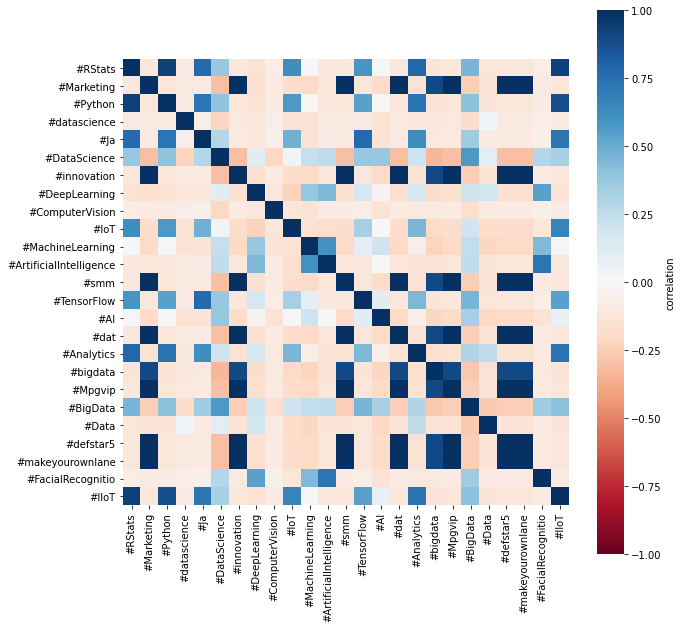

In [106]:
# plot the correlation matrix using heatmap
plt.figure(figsize = (10,10))
sns.heatmap(hashtag_correlations,
    cmap='RdBu',
    vmin=-1,
    vmax=1,
    square = True,
    cbar_kws={'label':'correlation'})
plt.show()

From the heatmap above, we can see there are some fairly strong correlation between:

- **#Marketing** and **#innovation**
- **#Marketing** and **#smm**
- **#Marketing** and **#dat**
- **#RStats** and **#Python**
- **#Marketing** and **#Mpgvip**
- **#lloT** and **#RStats**
    **......**

## Using LDA for topic modeling

In [108]:
# packages for nlp
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

In [110]:
def remove_links(tweet):
    '''Takes a string and removes web links from it'''
    tweet = re.sub(r'http\S+', '', tweet) # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet) # rempve bitly links
    tweet = tweet.strip('[link]') # remove [links]
    return tweet

def remove_users(tweet):
    '''Takes a string and removes retweet and @user information'''
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove retweet
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove tweeted at
    return tweet

In [173]:
# building a tweet cleaning pipeline
STOPWORDS = nltk.corpus.stopwords.words('english')
STOPWORDS.extend(['#datascience','datascience']) # add datascience to stopwords
word_rooter = nltk.stem.snowball.PorterStemmer(ignore_stopwords=False).stem
PUNCTUATION = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@…' # leave # in hashtags

def clean_tweet(tweet, bigrams=False):
    
    tweet = remove_users(tweet) # remove @mentions
    tweet = remove_links(tweet) # remove web links
    tweet = tweet.lower() # lower case
    tweet = re.sub('['+PUNCTUATION + ']+', ' ', tweet) # strip punctuation
    tweet = re.sub('\s+', ' ', tweet) #remove double spacing
    #tweet = re.sub('([0-9]+)', '', tweet) # remove numbers
    tweet_token_list = [word for word in tweet.split(' ')
                            if word not in STOPWORDS] # remove stopwords

    tweet_token_list = [word_rooter(word) if '#' not in word else word
                        for word in tweet_token_list] # apply word rooter
    
    # constructing bigrams
    if bigrams:
        tweet_token_list = tweet_token_list+[tweet_token_list[i]+'_'+tweet_token_list[i+1]
                                            for i in range(len(tweet_token_list)-1)]
    
    tweet = ' '.join(tweet_token_list)
    return tweet

In [174]:
df['clean_tweet'] = df.tweet.apply(clean_tweet)

In [175]:
df.head()

,tweet,is_retweet,hashtags,clean_tweet
0,RT @KirkDBorne: Biometric #IoT sensors shape t...,True,[#IoT],biometr #iot sensor shape futur user interfac
1,————,False,[],————
2,#BigData #DataScience #AI #Compute…,False,"[#BigData, #DataScience, #AI, #Compute]",#bigdata #ai #compute
3,RT @KirkDBorne: Understanding the 3 flavors of...,True,"[#MachineLearning, #ReinforcementLearning]",understand 3 flavor #machinelearning special ...
4,RT @R_Demidchuk: 30 #Blockchain use-cases outs...,True,"[#Blockchain, #Fintech]",30 #blockchain use case outsid #fintech


In [176]:
# transforming the text into a sparse matrix
from sklearn.feature_extraction.text import CountVectorizer

# words appear less than 5 times or appear in more than 90% of tweets will be discarded
vectorizer = CountVectorizer(max_df=0.9, min_df=10, token_pattern='\w+|\$[\d\.]+|\S+')
tf = vectorizer.fit_transform(df['clean_tweet']).toarray()
tf_feature_names = vectorizer.get_feature_names()

In [177]:
tf.shape

(218, 17)

In [178]:
# printing the features
print(tf_feature_names)

['#5g', '#ai', '#analytics', '#bigdata', '#dat', '#data', '#deeplearning', '#defstar5', '#innovation', '#iot', '#machinelearning', '#makeyourownlane', '#marketing', '#mpgvip', '#smm', 'data', 'war']


In [185]:
# package that contains LDA algorithm
from sklearn.decomposition import LatentDirichletAllocation

# choosing the number of topics
number_of_topics = 7

# fitting the LDA model
model = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)
model.fit(tf)

LatentDirichletAllocation(n_components=7, random_state=0)

In [186]:
def display_topics(model, feature_names, no_top_words):
    '''Takes a model object, the feature name matrix, and the number of words to display and returns a dataframe'''
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

In [187]:
# displaying the topics
no_top_words = 5
display_topics(model, tf_feature_names, no_top_words)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights,Topic 6 words,Topic 6 weights
0,#5g,11.1,#dat,11.1,#innovation,1.1,#iot,18.1,#ai,17.9,#machinelearning,19.1,#data,11.1
1,war,10.1,#bigdata,10.1,#bigdata,0.1,#bigdata,8.6,#bigdata,14.3,#deeplearning,15.1,#analytics,0.1
2,#iot,0.1,#smm,10.1,data,0.1,#analytics,8.1,data,12.1,#bigdata,7.5,data,0.1
3,#bigdata,0.1,#mpgvip,10.1,#ai,0.1,#ai,2.4,#machinelearning,0.1,#analytics,4.1,#deeplearning,0.1
4,data,0.1,#marketing,10.1,#machinelearning,0.1,#machinelearning,2.1,#dat,0.1,#ai,0.1,#bigdata,0.1


From the table above, we can identify some interesting topics around "data science".

- **5G**
- **Social Media Marketing**
- **IoT**
- **Machine Learning**/**Deep Learning**
- **Data......**

## Using NMF for topic modeling

LDA works very well for longer text documents, but may not perform equally well on short text documents like tweets. In the following section, I will replace the LDA model with an NMF(non-negative matrix factorisation) to generate a new set of topics.

In [188]:
# package that contains NMF algorithm
from sklearn.decomposition import NMF

# choosing the number of topics
number_of_topics = 7

# fitting the NMF model
NMF_model = NMF(n_components=number_of_topics, random_state=0, alpha=.1, l1_ratio=.5)
NMF_model.fit(tf)

NMF(alpha=0.1, l1_ratio=0.5, n_components=7, random_state=0)

In [189]:
# displaying the topics
no_top_words = 5
display_topics(NMF_model, tf_feature_names, no_top_words)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights,Topic 6 words,Topic 6 weights
0,#bigdata,1.1,#ai,2.5,#iot,2.0,#5g,1.8,#data,1.7,data,2.2,#machinelearning,2.2
1,#innovation,1.1,#bigdata,1.0,#bigdata,1.4,war,1.7,#deeplearning,1.1,#data,0.2,#deeplearning,1.3
2,#dat,1.1,#machinelearning,0.0,#analytics,1.3,#iot,0.0,#analytics,0.9,war,0.0,#bigdata,1.1
3,#smm,1.1,#dat,0.0,#5g,0.0,#smm,0.0,war,0.0,#defstar5,0.0,war,0.0
4,#mpgvip,1.1,war,0.0,#defstar5,0.0,#mpgvip,0.0,#defstar5,0.0,#ai,0.0,#defstar5,0.0
